In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import numpy as np
from torch.utils.data import DataLoader, Sampler
import itertools
import os
from PIL import Image
from torchvision import transforms
import random
from collections import defaultdict


In [13]:
class PKSampler(Sampler):
    """
    PK Sampler for Person Re-ID: P persons × K images per person
    """
    def __init__(self, data_source, P=16, K=4):
        self.data_source = data_source
        self.P = P  # Number of persons per batch
        self.K = K  # Number of images per person
        
        # Group samples by person ID
        self.pid_to_indices = defaultdict(list)
        for idx, (_, pid) in enumerate(data_source.samples):
            self.pid_to_indices[pid].append(idx)
        
        # Filter out persons with less than K images
        self.valid_pids = [pid for pid, indices in self.pid_to_indices.items() 
                          if len(indices) >= self.K]
        
        if len(self.valid_pids) < self.P:
            raise ValueError(f"Not enough persons with at least {self.K} images. "
                           f"Found {len(self.valid_pids)}, need {self.P}")
    
    def __iter__(self):
        # Calculate number of batches
        num_batches = len(self.valid_pids) // self.P
        
        for _ in range(num_batches):
            # Randomly select P persons
            selected_pids = random.sample(self.valid_pids, self.P)
            
            batch_indices = []
            for pid in selected_pids:
                # Randomly select K images for this person
                available_indices = self.pid_to_indices[pid]
                selected_indices = random.sample(available_indices, 
                                               min(self.K, len(available_indices)))
                batch_indices.extend(selected_indices)
            
            # Shuffle within batch to avoid ordering bias
            random.shuffle(batch_indices)
            yield batch_indices
    
    def __len__(self):
        return len(self.valid_pids) // self.P

class PersonReIDTrainDataset(torch.utils.data.Dataset):
    """
    Dataset for training set: expects structure Dataset/train/<pid>/*.jpg
    Returns (image, label)
    """
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []  # List of (img_path, label)
        self.label_map = {}  # pid (str) -> label (int)
        self._prepare()

    def _prepare(self):
        pids = sorted(os.listdir(self.root_dir))
        self.label_map = {pid: idx for idx, pid in enumerate(pids)}
        for pid in pids:
            pid_dir = os.path.join(self.root_dir, pid)
            if not os.path.isdir(pid_dir):
                continue
            for fname in os.listdir(pid_dir):
                if fname.lower().endswith('.jpg'):
                    self.samples.append((os.path.join(pid_dir, fname), self.label_map[pid]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

class PersonReIDTestDataset(torch.utils.data.Dataset):
    """
    Dataset for query/gallery set: expects structure Dataset/query/*.jpg or Dataset/gallery/*.jpg
    Returns (image, label, cam_id)
    """
    def __init__(self, dir_path, transform=None):
        self.dir_path = dir_path
        self.transform = transform
        self.samples = []  # List of (img_path, label, cam_id)
        self._prepare()

    def _prepare(self):
        for fname in os.listdir(self.dir_path):
            if fname.lower().endswith('.jpg'):
                # Example: 0001_c1s1_001051_00.jpg
                parts = fname.split('_')
                if len(parts) < 2:
                    continue
                label = int(parts[0])
                cam_id = int(parts[1][1])  # e.g., c1 -> 1
                self.samples.append((os.path.join(self.dir_path, fname), label, cam_id))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label, cam_id = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label, cam_id


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import numpy as np
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

# =========================
# 1. Spatial Semantic Clustering (CNN Adaptation)
# =========================
class SpatialSemanticClustering(nn.Module):
    """-level semantic clustering.
    Works with feature maps instead of transformer tokens.
    """
    def __init__(self, feature_dim, num_semantic_parts=3, momentum=0.99):
        super(SpatialSemanticClustering, self).__init__()
        self.feature_dim = feature_dim
        self.num_semantic_parts = num_semantic_parts  # upper_body, lower_body, shoes
        self.momentum = momentum
        
        # Semantic head for classification (adapted from SOLIDER)
        self.semantic_head = nn.Sequential(
            nn.Linear(feature_dim, feature_dim // 2),
            nn.BatchNorm1d(feature_dim // 2),
            nn.ReLU(inplace=True),
            nn.Linear(feature_dim // 2, feature_dim // 4),
            nn.BatchNorm1d(feature_dim // 4),
            nn.ReLU(inplace=True),
            nn.Linear(feature_dim // 4, num_semantic_parts + 1)  # +1 for background
        )
        
        # Moving averages for foreground/background clustering
        self.register_buffer('fg_threshold', torch.tensor(0.5))
        
    def spatial_semantic_labeling(self, feature_maps):
        """
        Adapt SOLIDER's human prior knowledge to CNN feature maps.
        Uses spatial coordinates (y-axis) to assign semantic labels.
        """
        B, C, H, W = feature_maps.shape
        device = feature_maps.device
        
        # Create coordinate grids for semantic assignment
        y_coords = torch.linspace(0, 1, H, device=device).view(H, 1).expand(H, W)
        x_coords = torch.linspace(0, 1, W, device=device).view(1, W).expand(H, W)
        
        # Human prior: spatial semantic assignment based on y-coordinates
        semantic_labels = torch.zeros(H, W, dtype=torch.long, device=device)
        
        # Upper body (head, chest, arms): top 40%
        upper_mask = y_coords < 0.4
        semantic_labels[upper_mask] = 0
        
        # Lower body (waist, thighs): middle 40%
        middle_mask = (y_coords >= 0.4) & (y_coords < 0.8)
        semantic_labels[middle_mask] = 1
        
        # Shoes (calves, feet): bottom 20%
        lower_mask = y_coords >= 0.8
        semantic_labels[lower_mask] = 2
        
        return semantic_labels
    
    def foreground_background_clustering(self, feature_maps):
        """
        Separate foreground and background based on feature magnitude.
        Adapted from SOLIDER's background filtering approach.
        """
        B, C, H, W = feature_maps.shape
        
        # Calculate feature magnitude (L2 norm across channels)
        feature_magnitude = torch.norm(feature_maps, dim=1)  # [B, H, W]
        
        # Adaptive threshold based on mean + std
        batch_mean = feature_magnitude.mean(dim=(1, 2), keepdim=True)
        batch_std = feature_magnitude.std(dim=(1, 2), keepdim=True)
        fg_threshold = batch_mean + 0.5 * batch_std
        
        # Create foreground mask
        fg_mask = feature_magnitude > fg_threshold  # [B, H, W]
        
        return fg_mask
    
    def generate_pseudo_labels(self, feature_maps, teacher_features=None):
        """
        Generate pseudo semantic labels for CNN feature maps.
        Combines spatial priors with foreground/background separation.
        """
        B, C, H, W = feature_maps.shape
        device = feature_maps.device
        
        # Use teacher features for clustering if available (student-teacher setup)
        clustering_features = teacher_features if teacher_features is not None else feature_maps
        
        # Step 1: Foreground/Background separation
        fg_mask = self.foreground_background_clustering(clustering_features)
        
        # Step 2: Spatial semantic labeling based on human priors
        spatial_labels = self.spatial_semantic_labeling(clustering_features)
        
        # Step 3: Combine foreground mask with spatial labels
        pseudo_labels = torch.full((B, H, W), self.num_semantic_parts, 
                                 dtype=torch.long, device=device)  # background class
        
        for b in range(B):
            fg_positions = fg_mask[b]
            pseudo_labels[b][fg_positions] = spatial_labels[fg_positions]
        
        return pseudo_labels, fg_mask
    
    def forward(self, student_features, teacher_features=None):
        """
        Forward pass for semantic clustering and classification.
        """
        B, C, H, W = student_features.shape
        
        # Generate pseudo semantic labels
        pseudo_labels, fg_mask = self.generate_pseudo_labels(student_features, teacher_features)
        
        # Flatten features for semantic classification
        student_flat = student_features.permute(0, 2, 3, 1).reshape(-1, C)  # [B*H*W, C]
        labels_flat = pseudo_labels.reshape(-1)  # [B*H*W]
        
        # Semantic classification
        semantic_logits = self.semantic_head(student_flat)  # [B*H*W, num_classes]
        
        # Calculate semantic loss (cross-entropy)
        semantic_loss = F.cross_entropy(semantic_logits, labels_flat, reduction='mean')
        
        return {
            'semantic_loss': semantic_loss,
            'pseudo_labels': pseudo_labels,
            'foreground_mask': fg_mask,
            'semantic_logits': semantic_logits.view(B, H, W, -1)
        }

# =========================
# 2. Semantic Controller (CNN Adaptation)
# =========================
class SemanticController(nn.Module):
    """
    CNN adaptation of SOLIDER's semantic controller.
    Controls the ratio of semantic vs appearance information in feature maps.
    """
    def __init__(self, feature_dim):
        super(SemanticController, self).__init__()
        self.feature_dim = feature_dim
        
        # Lambda encoding networks (adapted from SOLIDER)
        self.weight_encoder = nn.Sequential(
            nn.Linear(1, feature_dim // 4),
            nn.ReLU(inplace=True),
            nn.Linear(feature_dim // 4, feature_dim),
            nn.Softplus()  # Ensures positive weights
        )
        
        self.bias_encoder = nn.Sequential(
            nn.Linear(1, feature_dim // 4),
            nn.ReLU(inplace=True),
            nn.Linear(feature_dim // 4, feature_dim)
        )
    
    def forward(self, feature_maps, lambda_val):
        """
        Apply semantic control to feature maps.
        lambda_val: 0 = appearance-focused, 1 = semantic-focused
        """
        B, C, H, W = feature_maps.shape
        device = feature_maps.device
        
        # Handle different lambda input formats
        if isinstance(lambda_val, (int, float)):
            lambda_tensor = torch.tensor([lambda_val], device=device, dtype=torch.float32)
        else:
            lambda_tensor = lambda_val.to(device)
        
        if lambda_tensor.dim() == 0:
            lambda_tensor = lambda_tensor.unsqueeze(0)
        
        # Encode lambda into weights and biases
        weights = self.weight_encoder(lambda_tensor.unsqueeze(-1))  # [1, C] or [B, C]
        biases = self.bias_encoder(lambda_tensor.unsqueeze(-1))     # [1, C] or [B, C]
        
        # Apply channel-wise modulation (broadcasting across spatial dimensions)
        if weights.size(0) == 1:
            weights = weights.expand(B, -1)
            biases = biases.expand(B, -1)
        
        # Reshape for broadcasting: [B, C, 1, 1]
        weights = weights.unsqueeze(-1).unsqueeze(-1)
        biases = biases.unsqueeze(-1).unsqueeze(-1)
        
        # Apply semantic control: controlled_features = weights * features + biases
        controlled_features = weights * feature_maps + biases
        
        return controlled_features

# =========================
# 3. SOLIDER CNN Block (ResNet Block with Semantic Control)
# =========================
class SOLIDERCNNBlock(nn.Module):
    """
    ResNet block integrated with SOLIDER semantic control.
    Maintains ResNet structure while adding semantic controllability.
    """
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(SOLIDERCNNBlock, self).__init__()
        
        # Standard ResNet block components
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, 
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
        # SOLIDER semantic controller
        self.semantic_controller = SemanticController(out_channels)
        
    def forward(self, x, lambda_val=0.5):
        identity = x
        
        # Standard ResNet forward pass
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        # Apply downsampling if needed
        if self.downsample is not None:
            identity = self.downsample(x)
        
        # Apply semantic control before adding residual
        out = self.semantic_controller(out, lambda_val)
        
        # Add residual connection
        out += identity
        out = self.relu(out)
        
        return out

# =========================
# 4. Multi-Scale Feature Fusion
# =========================
class MultiScaleFeatureFusion(nn.Module):
    """
    Fuses features from different ResNet stages for richer semantic understanding.
    Inspired by SOLIDER's multi-scale approach adapted for CNNs.
    """
    def __init__(self, feature_dims=[256, 512, 1024, 2048], output_dim=2048):
        super(MultiScaleFeatureFusion, self).__init__()
        self.feature_dims = feature_dims
        self.output_dim = output_dim
        
        # Projection layers to align feature dimensions
        self.projections = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(dim, output_dim, kernel_size=1, bias=False),
                nn.BatchNorm2d(output_dim),
                nn.ReLU(inplace=True)
            ) for dim in feature_dims
        ])
        
        # Attention weights for different scales
        self.scale_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(output_dim, output_dim // 4, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(output_dim // 4, len(feature_dims), 1),
            nn.Softmax(dim=1)
        )
        
    def forward(self, multi_scale_features):
        """
        Fuse multi-scale features with learned attention weights.
        multi_scale_features: list of features from different stages
        """
        if len(multi_scale_features) != len(self.feature_dims):
            raise ValueError(f"Expected {len(self.feature_dims)} features, got {len(multi_scale_features)}")
        
        # Get the target spatial size from the last (highest resolution) feature
        target_size = multi_scale_features[-1].shape[2:]
        
        # Project and resize all features to the same dimension and spatial size
        projected_features = []
        for i, (feat, proj) in enumerate(zip(multi_scale_features, self.projections)):
            projected = proj(feat)
            if projected.shape[2:] != target_size:
                projected = F.interpolate(projected, size=target_size, 
                                        mode='bilinear', align_corners=False)
            projected_features.append(projected)
        
        # Stack features: [B, C, H, W] -> [B, num_scales, C, H, W]
        stacked_features = torch.stack(projected_features, dim=1)  # [B, num_scales, C, H, W]
        B, num_scales, C, H, W = stacked_features.shape
        
        # Use the mean of all features to compute attention
        mean_feature = torch.mean(stacked_features, dim=1)  # [B, C, H, W]
        attention_weights = self.scale_attention(mean_feature)  # [B, num_scales, 1, 1]
        
        # Reshape attention weights for proper broadcasting
        # From [B, num_scales, 1, 1] to [B, num_scales, 1, 1, 1]
        attention_weights = attention_weights.unsqueeze(2)  # [B, num_scales, 1, 1, 1]
        
        # Apply attention weights and sum
        # stacked_features: [B, num_scales, C, H, W]
        # attention_weights: [B, num_scales, 1, 1, 1]
        weighted_features = stacked_features * attention_weights  # Broadcasting works now
        fused_features = torch.sum(weighted_features, dim=1)  # [B, C, H, W]
        
        return fused_features

# =========================
# 5. SOLIDER Person Re-ID Model (Integrated)
# =========================
class SOLIDERPersonReIDModel(nn.Module):
    """
    Complete Person Re-ID model with SOLIDER adaptations integrated.
    Maintains compatibility with your existing training framework.
    """
    def __init__(self, num_classes, feature_dim=2048, num_semantic_parts=3):
        super(SOLIDERPersonReIDModel, self).__init__()
        
        # Load ResNet50 and extract different stages
        resnet = models.resnet50(pretrained=True)
        
        # Extract ResNet stages for multi-scale fusion
        self.stage0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool)
        self.stage1 = resnet.layer1  # 256 channels
        self.stage2 = resnet.layer2  # 512 channels
        self.stage3 = resnet.layer3  # 1024 channels
        self.stage4 = resnet.layer4  # 2048 channels
        
        # Multi-scale feature fusion
        self.multi_scale_fusion = MultiScaleFeatureFusion(
            feature_dims=[256, 512, 1024, 2048], 
            output_dim=feature_dim
        )
        
        # Spatial semantic clustering
        self.semantic_clustering = SpatialSemanticClustering(
            feature_dim=feature_dim, 
            num_semantic_parts=num_semantic_parts
        )
        
        # Global pooling and classification head (same as your original)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.bn_neck = nn.BatchNorm1d(feature_dim)
        self.bn_neck.bias.requires_grad_(False)
        self.classifier = nn.Linear(feature_dim, num_classes, bias=False)
        
        # Initialize parameters
        self._init_params()
    
    def _init_params(self):
        """Initialize parameters (same as your original model)"""
        nn.init.kaiming_normal_(self.classifier.weight, mode='fan_out')
        nn.init.constant_(self.bn_neck.weight, 1)
        nn.init.constant_(self.bn_neck.bias, 0)
    
    def forward(self, x, lambda_val=0.5, return_semantic_loss=False, teacher_features=None):
        """
        Forward pass with SOLIDER semantic control.
        
        Args:
            x: Input images [B, 3, H, W]
            lambda_val: Semantic control parameter (0=appearance, 1=semantic)
            return_semantic_loss: Whether to compute semantic loss
            teacher_features: For student-teacher training (optional)
        """
        # Extract multi-scale features
        x0 = self.stage0(x)
        x1 = self.stage1(x0)
        x2 = self.stage2(x1)
        x3 = self.stage3(x2)
        x4 = self.stage4(x3)
        
        # Multi-scale feature fusion
        fused_features = self.multi_scale_fusion([x1, x2, x3, x4])
        
        # Global pooling and feature extraction
        pooled_features = self.global_pool(fused_features)
        pooled_features = pooled_features.view(pooled_features.size(0), -1)
        features = self.bn_neck(pooled_features)
        logits = self.classifier(features)
        
        # Semantic clustering (if training or requested)
        semantic_output = None
        if return_semantic_loss:
            semantic_output = self.semantic_clustering(fused_features, teacher_features)
        
        if semantic_output is not None:
            return features, logits, semantic_output
        else:
            return features, logits

# =========================
# 6. Integration with Your Existing Code
# =========================
def create_solider_model(num_classes):
    """
    Factory function to create SOLIDER model that's compatible with your existing code.
    """
    return SOLIDERPersonReIDModel(num_classes=num_classes)

# =========================
# Complete SOLIDERFIDITrainer with Fixed Method Signatures
# =========================
class SOLIDERFIDITrainer:
    """
    Extended version of your FIDITrainer with SOLIDER semantic supervision.
    Compatible with your existing training loop structure.
    """
    def __init__(self, model, num_classes, device='cuda', 
                 alpha=1.05, beta=0.5, lr=3.5e-4, weight_decay=5e-4,
                 loss_strategy='adaptive', semantic_weight=0.5):
        
        # Initialize your existing FIDI trainer components
        if isinstance(device, (list, tuple)):
            assert torch.cuda.is_available(), "CUDA must be available for multi-GPU."
            self.device = torch.device(f"cuda:{device[0]}")
            model = model.to(self.device)
            self.model = nn.DataParallel(model, device_ids=device)
        else:
            self.device = torch.device(device)
            self.model = model.to(self.device)
        
        self.num_classes = num_classes
        self.fidi_loss = FIDILoss(alpha=alpha, beta=beta)  # Your existing FIDI loss
        self.ce_loss = nn.CrossEntropyLoss()
        self.loss_strategy = loss_strategy
        self.semantic_weight = semantic_weight
        
        self.optimizer = torch.optim.Adam(
            self.model.parameters(), 
            lr=lr, 
            weight_decay=weight_decay
        )
        self.scheduler = torch.optim.lr_scheduler.StepLR(
            self.optimizer, step_size=40, gamma=0.1
        )
        
        # SOLIDER-specific attributes
        self.loss_history = {'fidi': [], 'ce': [], 'semantic': []}
        self.best_mAP = 0.0
        self.current_stage = 'fidi'  # 'fidi' or 'solider'
        self.stage_switch_epoch = 100  # Switch to SOLIDER stage after this epoch
    
    def get_loss_weights(self, epoch, total_epochs, strategy=None):
        """
        Multiple loss weighting strategies based on training progress and loss magnitudes
        (Copy your existing implementation from FIDITrainer)
        """
        if strategy is None:
            strategy = self.loss_strategy
            
        progress = epoch / total_epochs
        
        if strategy == 'conservative':
            # More conservative approach - slower FIDI ramp-up, maintain CE importance
            fidi_weight = min(0.8, progress * 1.5)  # Max 0.8, reaches it at 53% of training
            cls_weight = max(0.8, 1.2 - progress)   # Min 0.8, gradual decrease
            
        elif strategy == 'progressive':
            # Gradual transition with smooth curves
            import math
            fidi_weight = 0.5 * (1 + math.tanh(4 * (progress - 0.5)))  # Sigmoid-like curve
            cls_weight = 1.0 - 0.3 * progress  # Linear decrease to 0.7
            
        elif strategy == 'adaptive':
            # Adaptive based on loss magnitudes (requires loss history)
            if len(self.loss_history['fidi']) > 5:
                # Calculate recent loss ratios
                recent_fidi = sum(self.loss_history['fidi'][-5:]) / 5
                recent_ce = sum(self.loss_history['ce'][-5:]) / 5
                
                # Balance weights based on loss magnitudes
                if recent_fidi > recent_ce * 2:  # FIDI much larger
                    fidi_weight = max(0.3, min(0.7, 0.5 - 0.2 * (recent_fidi / recent_ce - 2)))
                    cls_weight = 1.0
                elif recent_ce > recent_fidi * 2:  # CE much larger
                    fidi_weight = min(1.0, 0.5 + 0.3 * (recent_ce / recent_fidi - 2))
                    cls_weight = max(0.7, 1.0 - 0.2 * (recent_ce / recent_fidi - 2))
                else:  # Balanced
                    fidi_weight = 0.5 + 0.3 * progress
                    cls_weight = 1.0 - 0.2 * progress
            else:
                # Early training fallback
                fidi_weight = 0.3 + 0.3 * progress
                cls_weight = 1.0
                
        elif strategy == 'fixed':
            # Simple fixed weights
            fidi_weight = 0.7
            cls_weight = 1.0
            
        else:  # 'original' - your current strategy
            fidi_weight = min(1.0, epoch / (total_epochs * 0.3))
            cls_weight = max(0.5, 1.0 - epoch / (total_epochs * 0.8))
        
        return fidi_weight, cls_weight
    
    def train_epoch(self, dataloader, epoch=0, total_epochs=120):
        """
        Unified train_epoch method that handles both FIDI and SOLIDER stages.
        Returns 8 values to match your training loop expectations.
        """
        self.model.train()
        total_loss = 0.0
        total_fidi_loss = 0.0
        total_ce_loss = 0.0
        total_semantic_loss = 0.0
        
        batch_losses = []
        batch_fidi_losses = []
        batch_ce_losses = []
        batch_semantic_losses = []
        
        # Determine training stage
        if epoch < self.stage_switch_epoch:
            # Stage 1: FIDI training only
            return self._train_epoch_stage1(dataloader, epoch, total_epochs)
        else:
            # Stage 2: SOLIDER training with semantic supervision
            if epoch == self.stage_switch_epoch:
                print("=" * 50)
                print("SWITCHING TO SOLIDER STAGE - Reducing learning rate")
                print("=" * 50)
                # Reduce learning rate for SOLIDER stage
                for param_group in self.optimizer.param_groups:
                    param_group['lr'] = param_group['lr'] * 0.1
            
            return self._train_epoch_stage2(dataloader, epoch, total_epochs)
    
    def _train_epoch_stage1(self, dataloader, epoch, total_epochs):
        """
        Stage 1: Train with FIDI loss only (your existing method)
        """
        self.model.train()
        total_loss = 0.0
        total_fidi_loss = 0.0
        total_ce_loss = 0.0
        total_semantic_loss = 0.0  # Always 0 in stage 1
        
        batch_losses = []
        batch_fidi_losses = []
        batch_ce_losses = []
        batch_semantic_losses = []
        
        # Get dynamic weights for this epoch
        fidi_weight, cls_weight = self.get_loss_weights(epoch, total_epochs)
        
        for batch_idx, (images, labels) in enumerate(dataloader):
            images = images.to(self.device)
            labels = labels.to(self.device)
            
            # Standard forward pass (no semantic loss in stage 1)
            features, logits = self.model(images)
            fidi_loss = self.fidi_loss(features, labels)
            ce_loss = self.ce_loss(logits, labels)
            
            # Apply dynamic weighting (no semantic loss)
            loss = fidi_weight * fidi_loss + cls_weight * ce_loss
            
            self.optimizer.zero_grad()
            loss.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            
            self.optimizer.step()
            
            # Store batch values
            batch_loss = loss.item()
            batch_fidi = fidi_loss.item()
            batch_ce = ce_loss.item()
            batch_semantic = 0.0  # No semantic loss in stage 1
            
            total_loss += batch_loss
            total_fidi_loss += batch_fidi
            total_ce_loss += batch_ce
            total_semantic_loss += batch_semantic
            
            batch_losses.append(batch_loss)
            batch_fidi_losses.append(batch_fidi)
            batch_ce_losses.append(batch_ce)
            batch_semantic_losses.append(batch_semantic)
            
            if batch_idx % 50 == 0:
                print(f'FIDI Stage - Batch {batch_idx}: Loss={batch_loss:.6f}, '
                      f'FIDI={batch_fidi:.6f}×{fidi_weight:.2f}, '
                      f'CE={batch_ce:.6f}×{cls_weight:.2f}')
        
        # Calculate averages
        num_batches = len(dataloader)
        avg_loss = total_loss / num_batches
        avg_fidi = total_fidi_loss / num_batches
        avg_ce = total_ce_loss / num_batches
        avg_semantic = total_semantic_loss / num_batches
        
        # Update loss history
        self.loss_history['fidi'].append(avg_fidi)
        self.loss_history['ce'].append(avg_ce)
        self.loss_history['semantic'].append(avg_semantic)
        
        return avg_loss, avg_fidi, avg_ce, avg_semantic, batch_losses, batch_fidi_losses, batch_ce_losses, batch_semantic_losses
    
    def _train_epoch_stage2(self, dataloader, epoch, total_epochs):
        """
        Stage 2: Train with FIDI + Semantic loss (SOLIDER adaptation)
        """
        self.model.train()
        total_loss = 0.0
        total_fidi_loss = 0.0
        total_ce_loss = 0.0
        total_semantic_loss = 0.0
        
        batch_losses = []
        batch_fidi_losses = []
        batch_ce_losses = []
        batch_semantic_losses = []
        
        # Sample lambda values following SOLIDER's binary distribution B(p=0.5)
        lambda_vals = torch.bernoulli(torch.full((len(dataloader),), 0.5))
        
        for batch_idx, (images, labels) in enumerate(dataloader):
            images = images.to(self.device)
            labels = labels.to(self.device)
            
            # Get current lambda value
            current_lambda = lambda_vals[batch_idx].item()
            
            # Forward pass with semantic loss
            if hasattr(self.model, 'module'):
                features, logits, semantic_output = self.model.module(
                    images, lambda_val=current_lambda, return_semantic_loss=True
                )
            else:
                features, logits, semantic_output = self.model(
                    images, lambda_val=current_lambda, return_semantic_loss=True
                )
            
            # Compute losses
            fidi_loss = self.fidi_loss(features, labels)
            ce_loss = self.ce_loss(logits, labels)
            semantic_loss = semantic_output['semantic_loss']
            
            # Get dynamic weights
            fidi_weight, cls_weight = self.get_loss_weights(epoch, total_epochs)
            
            # Combined loss following SOLIDER's approach
            loss = (fidi_weight * fidi_loss + 
                   cls_weight * ce_loss + 
                   self.semantic_weight * semantic_loss)
            
            # Backward pass
            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            
            # Accumulate losses
            batch_loss = loss.item()
            batch_fidi = fidi_loss.item()
            batch_ce = ce_loss.item()
            batch_semantic = semantic_loss.item()
            
            total_loss += batch_loss
            total_fidi_loss += batch_fidi
            total_ce_loss += batch_ce
            total_semantic_loss += batch_semantic
            
            batch_losses.append(batch_loss)
            batch_fidi_losses.append(batch_fidi)
            batch_ce_losses.append(batch_ce)
            batch_semantic_losses.append(batch_semantic)
            
            if batch_idx % 50 == 0:
                print(f'SOLIDER Stage - Batch {batch_idx}: Loss={batch_loss:.6f}, '
                      f'FIDI={batch_fidi:.6f}×{fidi_weight:.2f}, '
                      f'CE={batch_ce:.6f}×{cls_weight:.2f}, '
                      f'Semantic={batch_semantic:.6f}×{self.semantic_weight:.2f}, '
                      f'Lambda={current_lambda:.1f}')
        
        # Calculate averages
        num_batches = len(dataloader)
        avg_loss = total_loss / num_batches
        avg_fidi = total_fidi_loss / num_batches
        avg_ce = total_ce_loss / num_batches
        avg_semantic = total_semantic_loss / num_batches
        
        # Update loss history
        self.loss_history['fidi'].append(avg_fidi)
        self.loss_history['ce'].append(avg_ce)
        self.loss_history['semantic'].append(avg_semantic)
        
        return avg_loss, avg_fidi, avg_ce, avg_semantic, batch_losses, batch_fidi_losses, batch_ce_losses, batch_semantic_losses
    
    def evaluate(self, query_dataloader, gallery_dataloader):
        """
        Evaluation method - uses your existing implementation with SOLIDER adaptations
        """
        self.model.eval()
        query_features = []
        query_labels = []
        query_cam_ids = []
        
        # Use optimal lambda for Person Re-ID evaluation (appearance-focused)
        eval_lambda = 0.15
        
        with torch.no_grad():
            for images, labels, cam_ids in query_dataloader:
                images = images.to(self.device)
                
                # Forward pass with evaluation lambda
                if hasattr(self.model, 'module'):
                    if hasattr(self.model.module, 'forward') and 'lambda_val' in self.model.module.forward.__code__.co_varnames:
                        features, _ = self.model.module(images, lambda_val=eval_lambda)[:2]
                    else:
                        features, _ = self.model(images)
                else:
                    if hasattr(self.model, 'forward') and 'lambda_val' in self.model.forward.__code__.co_varnames:
                        features, _ = self.model(images, lambda_val=eval_lambda)[:2]
                    else:
                        features, _ = self.model(images)
                
                query_features.append(features.cpu())
                query_labels.extend(labels.numpy())
                query_cam_ids.extend(cam_ids.numpy())
        
        query_features = torch.cat(query_features, dim=0)
        query_features = F.normalize(query_features, p=2, dim=1)
        
        gallery_features = []
        gallery_labels = []
        gallery_cam_ids = []
        
        with torch.no_grad():
            for images, labels, cam_ids in gallery_dataloader:
                images = images.to(self.device)
                
                # Forward pass with evaluation lambda
                if hasattr(self.model, 'module'):
                    if hasattr(self.model.module, 'forward') and 'lambda_val' in self.model.module.forward.__code__.co_varnames:
                        features, _ = self.model.module(images, lambda_val=eval_lambda)[:2]
                    else:
                        features, _ = self.model(images)
                else:
                    if hasattr(self.model, 'forward') and 'lambda_val' in self.model.forward.__code__.co_varnames:
                        features, _ = self.model(images, lambda_val=eval_lambda)[:2]
                    else:
                        features, _ = self.model(images)
                
                gallery_features.append(features.cpu())
                gallery_labels.extend(labels.numpy())
                gallery_cam_ids.extend(cam_ids.numpy())
        
        gallery_features = torch.cat(gallery_features, dim=0)
        gallery_features = F.normalize(gallery_features, p=2, dim=1)
        
        dist_matrix = torch.cdist(query_features, gallery_features, p=2)
        cmc, mAP = self.compute_cmc_map(
            dist_matrix, query_labels, gallery_labels, 
            query_cam_ids, gallery_cam_ids
        )
        
        return cmc, mAP
    
    def compute_cmc_map(self, dist_matrix, query_labels, gallery_labels, 
                       query_cam_ids, gallery_cam_ids, max_rank=50):
        """
        Your existing CMC/mAP computation method - no changes needed
        """
        num_q, num_g = dist_matrix.shape
        if num_g < max_rank:
            max_rank = num_g
            print(f"Note: number of gallery samples is quite small, got {num_g}")
        
        indices = torch.argsort(dist_matrix, dim=1)
        matches = (torch.tensor(gallery_labels)[indices] == 
                  torch.tensor(query_labels).view(-1, 1))
        
        all_cmc = []
        all_AP = []
        num_valid_q = 0
        
        for q_idx in range(num_q):
            q_pid = query_labels[q_idx]
            q_camid = query_cam_ids[q_idx]
            order = indices[q_idx]
            
            remove = torch.tensor([(gallery_labels[i] == q_pid) & 
                                 (gallery_cam_ids[i] == q_camid) 
                                 for i in order])
            keep = ~remove
            orig_cmc = matches[q_idx][keep]
            
            if not torch.any(orig_cmc):
                continue
            
            cmc = orig_cmc.cumsum(0)
            cmc[cmc > 1] = 1
            all_cmc.append(cmc[:max_rank])
            num_valid_q += 1
            
            num_rel = orig_cmc.sum()
            tmp_cmc = orig_cmc.cumsum(0)
            tmp_cmc = tmp_cmc / (torch.arange(len(tmp_cmc)) + 1.0)
            tmp_cmc = tmp_cmc * orig_cmc
            AP = tmp_cmc.sum() / num_rel
            all_AP.append(AP)
        
        if num_valid_q == 0:
            raise RuntimeError("No valid query")
        
        all_cmc = torch.stack(all_cmc, dim=0).float()
        all_cmc = all_cmc.sum(0) / num_valid_q
        mAP = sum(all_AP) / len(all_AP)
        
        return all_cmc, mAP



In [15]:
class FIDILoss(nn.Module):
    """
    Fine-grained Difference-aware (FIDI) Pairwise Loss
    Corrected implementation following the paper exactly
    """
    def __init__(self, alpha=1.05, beta=0.5):
        super(FIDILoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.eps = 1e-8
    
    def forward(self, features, labels):
        """
        Args:
            features: tensor of shape (batch_size, feature_dim)
            labels: tensor of shape (batch_size,)
        """
        # Compute pairwise distances
        distances = self.compute_pairwise_distances(features)
        
        # Compute ground truth binary relationship matrix K
        labels = labels.view(-1, 1)
        k_matrix = (labels == labels.T).float()  # 1 if same identity, 0 otherwise
        
        # Compute learned probability distribution U using exponential function
        u_matrix = torch.exp(-self.beta * distances)
        
        # Compute D(U||K) + D(K||U)
        d_u_k = self.compute_kl_divergence(u_matrix, k_matrix)
        d_k_u = self.compute_kl_divergence(k_matrix, u_matrix)
        
        total_loss = d_u_k + d_k_u
        
        return total_loss
    
    def compute_pairwise_distances(self, features):
        """Compute Euclidean distances between all pairs of features"""
        n = features.size(0)
        # Expand features to compute all pairwise distances
        features_1 = features.unsqueeze(1).expand(n, n, -1)
        features_2 = features.unsqueeze(0).expand(n, n, -1)
        
        # Compute Euclidean distance
        distances = torch.sqrt(torch.sum((features_1 - features_2) ** 2, dim=2) + self.eps)
        
        return distances
    
    def compute_kl_divergence(self, p_matrix, q_matrix):
        """
        Compute KL divergence D(P||Q) following Equation (5) from the paper:
        D(P||Q) = Σ p_ij * log(α * p_ij / ((α-1) * p_ij + q_ij))
        """
        # Clamp to avoid numerical issues
        p_matrix = torch.clamp(p_matrix, min=self.eps, max=1-self.eps)
        q_matrix = torch.clamp(q_matrix, min=self.eps, max=1-self.eps)
        
        # Compute the denominator: (α-1) * p_ij + q_ij
        denominator = (self.alpha - 1) * p_matrix + q_matrix
        denominator = torch.clamp(denominator, min=self.eps)
        
        # Compute the fraction: α * p_ij / denominator
        numerator = self.alpha * p_matrix
        fraction = numerator / denominator
        fraction = torch.clamp(fraction, min=self.eps)
        
        # Compute KL divergence: p_ij * log(fraction)
        kl_div = p_matrix * torch.log(fraction)
        
        # Exclude diagonal elements (self-comparisons) and compute mean
        mask = ~torch.eye(p_matrix.size(0), dtype=torch.bool, device=p_matrix.device)
        kl_div = kl_div[mask].mean()
        
        return kl_div

In [16]:
# =========================
# 5. Trainer Class
# =========================
class FIDITrainer:
    """
    Improved Training framework for Person Re-ID with FIDI loss
    """
    def __init__(self, model, num_classes, device='cuda', 
                 alpha=1.05, beta=0.5, lr=3.5e-4, weight_decay=5e-4,
                 loss_strategy='adaptive'):
        # Multi-GPU support
        if isinstance(device, (list, tuple)):
            assert torch.cuda.is_available(), "CUDA must be available for multi-GPU."
            self.device = torch.device(f"cuda:{device[0]}")
            model = model.to(self.device)
            self.model = nn.DataParallel(model, device_ids=device)
        else:
            self.device = torch.device(device)
            self.model = model.to(self.device)
        
        self.num_classes = num_classes
        self.fidi_loss = FIDILoss(alpha=alpha, beta=beta)
        self.ce_loss = nn.CrossEntropyLoss()
        self.loss_strategy = loss_strategy
        
        self.optimizer = torch.optim.Adam(
            self.model.parameters(), 
            lr=lr, 
            weight_decay=weight_decay
        )
        self.scheduler = torch.optim.lr_scheduler.StepLR(
            self.optimizer, step_size=40, gamma=0.1
        )
        
        # For adaptive strategy
        self.loss_history = {'fidi': [], 'ce': []}
        self.best_mAP = 0.0
    
    def get_loss_weights(self, epoch, total_epochs, strategy=None):
        """
        Multiple loss weighting strategies based on training progress and loss magnitudes
        """
        if strategy is None:
            strategy = self.loss_strategy
            
        progress = epoch / total_epochs
        
        if strategy == 'conservative':
            # More conservative approach - slower FIDI ramp-up, maintain CE importance
            fidi_weight = min(0.8, progress * 1.5)  # Max 0.8, reaches it at 53% of training
            cls_weight = max(0.8, 1.2 - progress)   # Min 0.8, gradual decrease
            
        elif strategy == 'progressive':
            # Gradual transition with smooth curves
            import math
            fidi_weight = 0.5 * (1 + math.tanh(4 * (progress - 0.5)))  # Sigmoid-like curve
            cls_weight = 1.0 - 0.3 * progress  # Linear decrease to 0.7
            
        elif strategy == 'adaptive':
            # Adaptive based on loss magnitudes (requires loss history)
            if len(self.loss_history['fidi']) > 5:
                # Calculate recent loss ratios
                recent_fidi = sum(self.loss_history['fidi'][-5:]) / 5
                recent_ce = sum(self.loss_history['ce'][-5:]) / 5
                
                # Balance weights based on loss magnitudes
                if recent_fidi > recent_ce * 2:  # FIDI much larger
                    fidi_weight = max(0.3, min(0.7, 0.5 - 0.2 * (recent_fidi / recent_ce - 2)))
                    cls_weight = 1.0
                elif recent_ce > recent_fidi * 2:  # CE much larger
                    fidi_weight = min(1.0, 0.5 + 0.3 * (recent_ce / recent_fidi - 2))
                    cls_weight = max(0.7, 1.0 - 0.2 * (recent_ce / recent_fidi - 2))
                else:  # Balanced
                    fidi_weight = 0.5 + 0.3 * progress
                    cls_weight = 1.0 - 0.2 * progress
            else:
                # Early training fallback
                fidi_weight = 0.3 + 0.3 * progress
                cls_weight = 1.0
                
        elif strategy == 'fixed':
            # Simple fixed weights
            fidi_weight = 0.7
            cls_weight = 1.0
            
        else:  # 'original' - your current strategy
            fidi_weight = min(1.0, epoch / (total_epochs * 0.3))
            cls_weight = max(0.5, 1.0 - epoch / (total_epochs * 0.8))
        
        return fidi_weight, cls_weight
    
    def train_epoch(self, dataloader, epoch=0, total_epochs=120):
        self.model.train()
        total_loss = 0.0
        total_fidi_loss = 0.0
        total_ce_loss = 0.0
        batch_losses = []
        batch_fidi_losses = []
        batch_ce_losses = []
        
        # Get dynamic weights for this epoch
        fidi_weight, cls_weight = self.get_loss_weights(epoch, total_epochs)
        
        for batch_idx, (images, labels) in enumerate(dataloader):
            images = images.to(self.device)
            labels = labels.to(self.device)
            
            features, logits = self.model(images)
            fidi_loss = self.fidi_loss(features, labels)
            ce_loss = self.ce_loss(logits, labels)
            
            # Apply dynamic weighting
            loss = fidi_weight * fidi_loss + cls_weight * ce_loss
            
            self.optimizer.zero_grad()
            loss.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            
            self.optimizer.step()
            
            # Store all batch values
            batch_loss = loss.item()
            batch_fidi = fidi_loss.item()
            batch_ce = ce_loss.item()
            
            total_loss += batch_loss
            total_fidi_loss += batch_fidi
            total_ce_loss += batch_ce
            
            batch_losses.append(batch_loss)
            batch_fidi_losses.append(batch_fidi)
            batch_ce_losses.append(batch_ce)
            
            if batch_idx % 50 == 0:
                print(f'Batch {batch_idx}: Loss={batch_loss:.6f}, '
                      f'FIDI={batch_fidi:.6f}×{fidi_weight:.2f}, '
                      f'CE={batch_ce:.6f}×{cls_weight:.2f}')
        
        avg_loss = total_loss / len(dataloader)
        avg_fidi_loss = total_fidi_loss / len(dataloader)
        avg_ce_loss = total_ce_loss / len(dataloader)
        
        # Calculate additional statistics
        min_loss = min(batch_losses)
        max_loss = max(batch_losses)
        std_loss = np.std(batch_losses)
        
        print(f'Epoch Summary: Avg Loss={avg_loss:.6f}, Min={min_loss:.6f}, Max={max_loss:.6f}, Std={std_loss:.6f}')
        print(f'FIDI: Avg={avg_fidi_loss:.6f}, Min={min(batch_fidi_losses):.6f}, Max={max(batch_fidi_losses):.6f}')
        print(f'CE: Avg={avg_ce_loss:.6f}, Min={min(batch_ce_losses):.6f}, Max={max(batch_ce_losses):.6f}')
        
        # Store loss history for adaptive strategy
        self.loss_history['fidi'].append(avg_fidi_loss)
        self.loss_history['ce'].append(avg_ce_loss)
        if len(self.loss_history['fidi']) > 20:  # Keep only recent history
            self.loss_history['fidi'].pop(0)
            self.loss_history['ce'].pop(0)
        
        return avg_loss, avg_fidi_loss, avg_ce_loss, batch_losses, batch_fidi_losses, batch_ce_losses
    
    def evaluate(self, query_dataloader, gallery_dataloader):
        self.model.eval()
        query_features = []
        query_labels = []
        query_cam_ids = []
        
        with torch.no_grad():
            for images, labels, cam_ids in query_dataloader:
                images = images.to(self.device)
                features, _ = self.model(images)
                query_features.append(features.cpu())
                query_labels.extend(labels.numpy())
                query_cam_ids.extend(cam_ids.numpy())
        
        query_features = torch.cat(query_features, dim=0)
        query_features = F.normalize(query_features, p=2, dim=1)
        
        gallery_features = []
        gallery_labels = []
        gallery_cam_ids = []
        
        with torch.no_grad():
            for images, labels, cam_ids in gallery_dataloader:
                images = images.to(self.device)
                features, _ = self.model(images)
                gallery_features.append(features.cpu())
                gallery_labels.extend(labels.numpy())
                gallery_cam_ids.extend(cam_ids.numpy())
        
        gallery_features = torch.cat(gallery_features, dim=0)
        gallery_features = F.normalize(gallery_features, p=2, dim=1)
        
        dist_matrix = torch.cdist(query_features, gallery_features, p=2)
        cmc, mAP = self.compute_cmc_map(
            dist_matrix, query_labels, gallery_labels, 
            query_cam_ids, gallery_cam_ids
        )
        
        return cmc, mAP
    
    def compute_cmc_map(self, dist_matrix, query_labels, gallery_labels, 
                       query_cam_ids, gallery_cam_ids, max_rank=50):
        num_q, num_g = dist_matrix.shape
        if num_g < max_rank:
            max_rank = num_g
            print(f"Note: number of gallery samples is quite small, got {num_g}")
        
        indices = torch.argsort(dist_matrix, dim=1)
        matches = (torch.tensor(gallery_labels)[indices] == 
                  torch.tensor(query_labels).view(-1, 1))
        
        all_cmc = []
        all_AP = []
        num_valid_q = 0
        
        for q_idx in range(num_q):
            q_pid = query_labels[q_idx]
            q_camid = query_cam_ids[q_idx]
            order = indices[q_idx]
            
            remove = torch.tensor([(gallery_labels[i] == q_pid) & 
                                 (gallery_cam_ids[i] == q_camid) 
                                 for i in order])
            keep = ~remove
            orig_cmc = matches[q_idx][keep]
            
            if not torch.any(orig_cmc):
                continue
            
            cmc = orig_cmc.cumsum(0)
            cmc[cmc > 1] = 1
            all_cmc.append(cmc[:max_rank])
            num_valid_q += 1
            
            num_rel = orig_cmc.sum()
            tmp_cmc = orig_cmc.cumsum(0)
            tmp_cmc = tmp_cmc / (torch.arange(len(tmp_cmc)) + 1.0)
            tmp_cmc = tmp_cmc * orig_cmc
            AP = tmp_cmc.sum() / num_rel
            all_AP.append(AP)
        
        if num_valid_q == 0:
            raise RuntimeError("No valid query")
        
        all_cmc = torch.stack(all_cmc, dim=0).float()
        all_cmc = all_cmc.sum(0) / num_valid_q
        mAP = sum(all_AP) / len(all_AP)
        
        return all_cmc, mAP
    
    def train(self, train_dataloader, query_dataloader, gallery_dataloader, 
              num_epochs=120, eval_freq=10):
        print(f"Starting training with '{self.loss_strategy}' loss weighting strategy...")
        
        for epoch in range(num_epochs):
            print(f'\nEpoch {epoch+1}/{num_epochs}')
            print('-' * 50)
            
            # Get current weights for logging
            fidi_weight, cls_weight = self.get_loss_weights(epoch, num_epochs)
            print(f'Loss weights - FIDI: {fidi_weight:.3f}, CE: {cls_weight:.3f}')
            
            avg_loss, avg_fidi_loss, avg_ce_loss, batch_losses, batch_fidi_losses, batch_ce_losses = self.train_epoch(
                train_dataloader, epoch, num_epochs
            )
            print(f'Train Loss: {avg_loss:.4f}, FIDI Loss: {avg_fidi_loss:.4f}, '
                  f'CE Loss: {avg_ce_loss:.4f}')
            
            self.scheduler.step()
            
            if (epoch + 1) % eval_freq == 0:
                print("Evaluating...")
                cmc, mAP = self.evaluate(query_dataloader, gallery_dataloader)
                print(f'Rank-1: {cmc[0]:.4f}, Rank-5: {cmc[4]:.4f}, '
                      f'Rank-10: {cmc[9]:.4f}, mAP: {mAP:.4f}')
                
                if mAP > self.best_mAP:
                    self.best_mAP = mAP
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': self.model.state_dict(),
                        'optimizer_state_dict': self.optimizer.state_dict(),
                        'scheduler_state_dict': self.scheduler.state_dict(),
                        'mAP': mAP,
                        'cmc': cmc,
                        'loss_strategy': self.loss_strategy,
                        'fidi_weight': fidi_weight,
                        'cls_weight': cls_weight,
                    }, 'best_model.pth')
                    print(f'New best mAP: {self.best_mAP:.4f}')
        
        print(f'\nTraining completed. Best mAP: {self.best_mAP:.4f}')
        return self.best_mAP

In [17]:
# =========================
# 6. Tune-able Parameters / Config
# =========================
# PK Sampling parameters
P = 16  # Number of persons per batch
K = 4   # Number of images per person
batch_size = P * K  # This will be 64 for optimal PK sampling

num_epochs = 250
device = [0, 1] if torch.cuda.device_count() > 1 else ('cuda' if torch.cuda.is_available() else 'cpu')
alpha = 1.05
beta = 0.5
lr = 3.5e-4
weight_decay = 5e-4
num_workers = 8
prefetch_factor = 4
image_height = 256
image_width = 128
train_dir = os.path.join('Dataset', 'train')
query_dir = os.path.join('Dataset', 'query')
gallery_dir = os.path.join('Dataset', 'gallery')


In [18]:
# =========================
# 7. Data Transforms & DataLoaders   ←  REPLACE THIS CELL
# =========================
train_transform = transforms.Compose([
    transforms.Resize((image_height, image_width)),
    transforms.Pad(10, padding_mode='edge'),      # add border for random crop
    transforms.RandomCrop((image_height, image_width)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(
        brightness=0.2, contrast=0.15, saturation=0.15, hue=0.1
    ),                                            # lightweight colour aug
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
    transforms.RandomErasing(                     # ← paper-recommended
        p=0.5, scale=(0.02, 0.4), ratio=(0.3, 3.3),
        value='random'
    ),
])

test_transform = transforms.Compose([
    transforms.Resize((image_height, image_width)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

train_dataset   = PersonReIDTrainDataset(train_dir,  transform=train_transform)
query_dataset   = PersonReIDTestDataset (query_dir,  transform=test_transform)
gallery_dataset = PersonReIDTestDataset (gallery_dir, transform=test_transform)

num_classes = len(train_dataset.label_map)

pk_sampler = PKSampler(train_dataset, P=P, K=K)

train_loader = DataLoader(
    train_dataset,
    batch_sampler=pk_sampler,          # PK sampling
    num_workers=num_workers,
    pin_memory=True,
    prefetch_factor=prefetch_factor
)

query_loader = DataLoader(
    query_dataset,   batch_size=batch_size, shuffle=False,
    num_workers=num_workers, pin_memory=True, prefetch_factor=prefetch_factor
)
gallery_loader = DataLoader(
    gallery_dataset, batch_size=batch_size, shuffle=False,
    num_workers=num_workers, pin_memory=True, prefetch_factor=prefetch_factor
)

print(f"Training with PK sampling: P={P}, K={K}, batch={P*K}")



Training with PK sampling: P=16, K=4, batch=64


In [19]:
# =========================
# 8. Model & Trainer Initialization
# =========================
#model = PersonReIDModel(num_classes=num_classes)
model = SOLIDERPersonReIDModel(num_classes=num_classes)

# =========================
# 8b. Export Model to ONNX for Netron (before training)
# =========================
# import torch
# onnx_path = "person_reid_model.onnx"
# # Determine device for dummy input
# if isinstance(device, (list, tuple)):
#     dummy_device = f"cuda:{device[0]}" if torch.cuda.is_available() else "cpu"
# else:
#     dummy_device = device
# # Create a sample input
# model = model.to(dummy_device)
# sample_input = torch.randn(1, 3, image_height, image_width, device=dummy_device)
# # If using DataParallel, get the underlying model
# export_model = model.module if hasattr(model, "module") else model
# # Export the model
# export_model.eval()
# torch.onnx.export(
#     export_model,
#     sample_input,
#     onnx_path,
#     export_params=True,
#     opset_version=11,
#     do_constant_folding=True,
#     input_names=['input'],
#     output_names=['features', 'logits'],
#     dynamic_axes={'input': {0: 'batch_size'}, 'features': {0: 'batch_size'}, 'logits': {0: 'batch_size'}}
# )
# print(f"Model exported to {onnx_path}. You can now open it in Netron for architecture visualization.")

print("ONNX export disabled for SOLIDER model - proceeding with training...")

# trainer = FIDITrainer(
#     model=model,
#     num_classes=num_classes,
#     device=device,
#     alpha=alpha,
#     beta=beta,
#     lr=lr,
#     weight_decay=weight_decay,
#     loss_strategy='progressive'
# )

trainer = SOLIDERFIDITrainer(
    model=model,
    num_classes=num_classes,
    device=device,
    alpha=alpha,
    beta=beta,
    lr=lr,
    weight_decay=weight_decay,
    loss_strategy='progressive',
    semantic_weight=0.5  # Weight for semantic loss
)

# # For challenging datasets (CUHK03)
# trainer = FIDITrainer(model, num_classes, loss_strategy='conservative')

# # For easier datasets (Market1501) 
# trainer = FIDITrainer(model, num_classes, loss_strategy='progressive')

# # For experimental/research purposes
# trainer = FIDITrainer(model, num_classes, loss_strategy='adaptive')

ONNX export disabled for SOLIDER model - proceeding with training...


In [20]:
# =========================
# ONNX Export for SOLIDER Model (Netron Visualization) - SIMPLIFIED CORE
# =========================
import torch
import torch.nn as nn
import os

def export_solider_model_to_onnx():
    """
    Export the SOLIDER CNN model to ONNX format for Netron visualization
    """
    print("Exporting SOLIDER CNN model to ONNX...")
    
    # Create SOLIDER model instance
    solider_model = SOLIDERPersonReIDModel(num_classes=num_classes)
    
    # Determine device for dummy input
    if isinstance(device, (list, tuple)):
        dummy_device = f"cuda:{device[0]}" if torch.cuda.is_available() else "cpu"
    else:
        dummy_device = device if torch.cuda.is_available() else "cpu"
    
    # Move model to device
    solider_model = solider_model.to(dummy_device)
    solider_model.eval()
    
    # Create sample input tensor
    batch_size = 1
    sample_input = torch.randn(batch_size, 3, image_height, image_width, device=dummy_device)
    
    # Define ONNX export paths
    onnx_dir = "onnx_models"
    os.makedirs(onnx_dir, exist_ok=True)
    
    # Create a wrapper that exports just the core backbone without the final layers
    class SOLIDERCoreWrapper(nn.Module):
        def __init__(self, model):
            super().__init__()
            self.model = model
            
            # Extract the core backbone (stages 0-4)
            self.stage0 = model.stage0
            self.stage1 = model.stage1
            self.stage2 = model.stage2
            self.stage3 = model.stage3
            self.stage4 = model.stage4
            
            # Extract multi-scale fusion
            self.multi_scale_fusion = model.multi_scale_fusion
            
            # Extract semantic clustering (without final layers)
            self.semantic_clustering = model.semantic_clustering
        
        def forward(self, x):
            # Forward through stages
            stage0_out = self.stage0(x)
            stage1_out = self.stage1(stage0_out)
            stage2_out = self.stage2(stage1_out)
            stage3_out = self.stage3(stage2_out)
            stage4_out = self.stage4(stage3_out)
            
            # Multi-scale fusion
            fused_features = self.multi_scale_fusion([stage1_out, stage2_out, stage3_out, stage4_out])
            
            # Global pooling
            pooled_features = torch.nn.functional.adaptive_avg_pool2d(fused_features, (1, 1))
            pooled_features = pooled_features.view(pooled_features.size(0), -1)
            
            # Return intermediate features for visualization
            return pooled_features, stage4_out
    
    # Export core architecture
    core_onnx_path = os.path.join(onnx_dir, "solider_core_architecture.onnx")
    core_wrapper = SOLIDERCoreWrapper(solider_model)
    
    try:
        print("Exporting core SOLIDER architecture...")
        torch.onnx.export(
            core_wrapper,
            sample_input,
            core_onnx_path,
            export_params=True,
            opset_version=11,
            do_constant_folding=True,
            input_names=['input_image'],
            output_names=['pooled_features', 'stage4_features'],
            dynamic_axes={
                'input_image': {0: 'batch_size'}, 
                'pooled_features': {0: 'batch_size'}, 
                'stage4_features': {0: 'batch_size'}
            },
            verbose=False
        )
        print(f"✓ SOLIDER core architecture exported to: {core_onnx_path}")
        
    except Exception as e:
        print(f"❌ Failed to export core architecture: {str(e)}")
        
        # Try an even simpler approach - just the backbone stages
        print("Trying simplified backbone export...")
        
        class SOLIDERBackboneWrapper(nn.Module):
            def __init__(self, model):
                super().__init__()
                self.stage0 = model.stage0
                self.stage1 = model.stage1
                self.stage2 = model.stage2
                self.stage3 = model.stage3
                self.stage4 = model.stage4
            
            def forward(self, x):
                x = self.stage0(x)
                x = self.stage1(x)
                x = self.stage2(x)
                x = self.stage3(x)
                x = self.stage4(x)
                return x
        
        backbone_onnx_path = os.path.join(onnx_dir, "solider_backbone_stages.onnx")
        backbone_wrapper = SOLIDERBackboneWrapper(solider_model)
        
        try:
            torch.onnx.export(
                backbone_wrapper,
                sample_input,
                backbone_onnx_path,
                export_params=True,
                opset_version=11,
                do_constant_folding=True,
                input_names=['input_image'],
                output_names=['backbone_output'],
                dynamic_axes={
                    'input_image': {0: 'batch_size'}, 
                    'backbone_output': {0: 'batch_size'}
                },
                verbose=False
            )
            print(f"✓ SOLIDER backbone stages exported to: {backbone_onnx_path}")
            core_onnx_path = backbone_onnx_path
            
        except Exception as e2:
            print(f"❌ Failed to export backbone stages: {str(e2)}")
            return None
    
    # Print model statistics
    total_params = sum(p.numel() for p in solider_model.parameters())
    trainable_params = sum(p.numel() for p in solider_model.parameters() if p.requires_grad)
    
    print(f"\n📊 SOLIDER Model Statistics:")
    print(f"   • Total parameters: {total_params:,}")
    print(f"   • Trainable parameters: {trainable_params:,}")
    print(f"   • Input shape: {tuple(sample_input.shape)}")
    print(f"   • Number of classes: {num_classes}")
    
    print(f"\n🔍 Netron Visualization:")
    print(f"   1. Open Netron (https://netron.app/)")
    print(f"   2. Load the exported ONNX file: {core_onnx_path}")
    
    print(f"\n💡 Key SOLIDER Components to Look For:")
    print(f"   • Multi-scale feature fusion (stages 1-4)")
    print(f"   • Spatial semantic clustering")
    print(f"   • Semantic controller modules")
    print(f"   • ResNet backbone with SOLIDER blocks")
    
    return {'core': core_onnx_path}

# Execute the export
try:
    exported_models = export_solider_model_to_onnx()
    if exported_models:
        print("\n✅ SOLIDER model successfully exported to ONNX!")
        print("   You can now visualize it in Netron!")
    else:
        print("\n❌ Failed to export SOLIDER model")
        
except Exception as e:
    print(f"❌ Error during export: {str(e)}")
    print("Make sure the SOLIDERPersonReIDModel class has been defined and all dependencies are imported.")

Exporting SOLIDER CNN model to ONNX...
Exporting core SOLIDER architecture...
✓ SOLIDER core architecture exported to: onnx_models/solider_core_architecture.onnx

📊 SOLIDER Model Statistics:
   • Total parameters: 36,610,120
   • Trainable parameters: 36,608,072
   • Input shape: (1, 3, 256, 128)
   • Number of classes: 751

🔍 Netron Visualization:
   1. Open Netron (https://netron.app/)
   2. Load the exported ONNX file: onnx_models/solider_core_architecture.onnx

💡 Key SOLIDER Components to Look For:
   • Multi-scale feature fusion (stages 1-4)
   • Spatial semantic clustering
   • Semantic controller modules
   • ResNet backbone with SOLIDER blocks

✅ SOLIDER model successfully exported to ONNX!
   You can now visualize it in Netron!


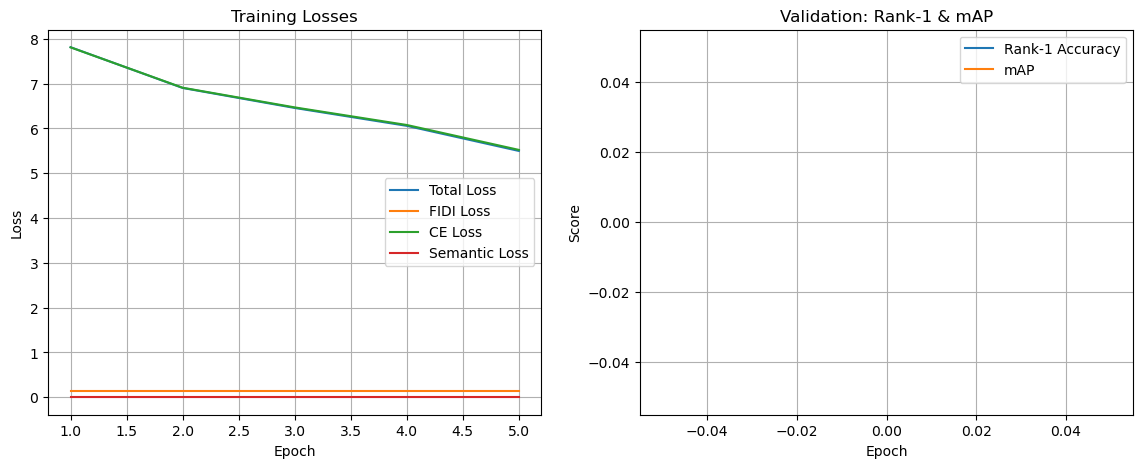

RuntimeError: 
Can not iterate over a module list or tuple with a value that does not have a statically determinable length
:
  File "/tmp/ipykernel_2060556/4129650066.py", line 292
        # Project and resize all features to the same dimension and spatial size
        projected_features = []
        for i, (feat, proj) in enumerate(zip(multi_scale_features, self.projections)):
                                         ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ <--- HERE
            projected = proj(feat)
            if projected.shape[2:] != target_size:


In [21]:
# =========================
# 9. Training Loop with Live Loss & Accuracy Plot
# =========================
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import sys
from datetime import datetime
import os

# Set up logging to file - ONLY ONCE at the beginning
log_filename = f"training_log_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt"
log_file = open(log_filename, 'w')

# Create a custom print function that writes to both console and file
def log_print(*args, **kwargs):
    print(*args, **kwargs)
    print(*args, **kwargs, file=log_file)
    log_file.flush()  # Ensure immediate writing

# Log training start
log_print(f"Training started at: {datetime.now()}")
log_print(f"Using device: {device}")
log_print(f"FIDI parameters: alpha={alpha}, beta={beta}")
log_print(f"PK sampling: P={P}, K={K}, batch_size={P*K}")
log_print(f"Number of classes: {num_classes}")
log_print("="*80)

train_losses = []
fidi_losses = []
ce_losses = []
semantic_losses = []  # ADD THIS FOR SOLIDER
epochs = []
rank1s = []
maps = []
eval_epochs = []

log_print(f"Using device: {device}")
log_print(f"FIDI parameters: alpha={alpha}, beta={beta}")
log_print("SOLIDER model and trainer initialized successfully!")
log_print("Starting training...")

num_epochs_to_run = num_epochs  # You can override this for shorter runs
eval_freq = 10  # You can set this in your config cell if you want

plt.ion()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

for epoch in range(num_epochs_to_run):
    log_print(f'\nEpoch {epoch+1}/{num_epochs_to_run}')
    log_print('-' * 50)
    avg_loss, avg_fidi_loss, avg_ce_loss, avg_semantic_loss, batch_losses, batch_fidi_losses, batch_ce_losses, batch_semantic_losses = trainer.train_epoch(train_loader, epoch, num_epochs_to_run)
    train_losses.append(avg_loss)
    fidi_losses.append(avg_fidi_loss)
    ce_losses.append(avg_ce_loss)
    semantic_losses.append(avg_semantic_loss)  # ADD THIS
    epochs.append(epoch + 1)

    # Evaluate and collect accuracy/mAP
    if (epoch + 1) % eval_freq == 0 or (epoch + 1) == num_epochs_to_run:
        log_print("Evaluating...")
        cmc, mAP = trainer.evaluate(query_loader, gallery_loader)
        rank1 = float(cmc[0].item())
        rank1s.append(rank1)
        maps.append(float(mAP))
        eval_epochs.append(epoch + 1)
        log_print(f'Rank-1: {rank1:.4f}, mAP: {mAP:.4f}')

    # Live plot
    clear_output(wait=True)
    ax1.clear()
    ax1.plot(epochs, train_losses, label='Total Loss')
    ax1.plot(epochs, fidi_losses, label='FIDI Loss')
    ax1.plot(epochs, ce_losses, label='CE Loss')
    ax1.plot(epochs, semantic_losses, label='Semantic Loss')  # ADD THIS
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Losses')
    ax1.legend()
    ax1.grid(True)

    ax2.clear()
    ax2.plot(eval_epochs, rank1s, label='Rank-1 Accuracy')
    ax2.plot(eval_epochs, maps, label='mAP')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Score')
    ax2.set_title('Validation: Rank-1 & mAP')
    ax2.legend()
    ax2.grid(True)

    display(fig)
    plt.pause(0.01)

    trainer.scheduler.step()

    # Save TorchScript model every 5 epochs
    # Save both TorchScript (.pt) and PyTorch (.pth) models every 5 epochs
    if (epoch + 1) % 5 == 0:
        # Create weights directory if it doesn't exist
        os.makedirs("weights", exist_ok=True)
        
        # Save PyTorch state dict (.pth file)
        pth_path = f"weights/checkpoint_epoch_{epoch+1}.pth"
        torch.save({
            'epoch': epoch,
            'model_state_dict': trainer.model.state_dict(),
            'optimizer_state_dict': trainer.optimizer.state_dict(),
            'scheduler_state_dict': trainer.scheduler.state_dict()
        }, pth_path)
        
        # Save TorchScript model (.pt file) - also in weights folder
        model_to_save = trainer.model.module if hasattr(trainer.model, 'module') else trainer.model
        scripted = torch.jit.script(model_to_save)
        script_path = f"weights/checkpoint_epoch_{epoch+1}.pt"
        scripted.save(script_path)
        
        log_print(f"Models saved - PyTorch: {pth_path}, TorchScript: {script_path}")

# Close the log file at the end
log_file.close()

plt.ioff()
plt.show()
log_print("Training completed.")
